In [6]:
from DataLoader import HeartFailureDataset
import pandas as pd
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns

load_data = HeartFailureDataset()
X = load_data.get_features()
y = load_data.get_targets()

First, we examine our dataset by considering the values of the dependent variable $y$. The target variable $y \in \{0,1\}$ is binary and takes on the following values:

<div style="text-align: center;">

$$
y = \begin{cases}
1 & \text{indicates a death event} \\
0 & \text{indicates survival}
\end{cases}
$$

</div>

We have $n = 300$ many data points and $d = 12$ different "features":

    1. Age; patient age, in years
    2. Anemia; decrease in red blood cells or hemoglobin,
    3. Creatinine; CPK enzyme levels in the blood (mcg/L),
    4. Diabetes; whether the patient is diabetic,
    5. Ejection fraction (EF); the percentage of blood that leaves the heart with each contraction
    6. High blood pressure; whether the patient has hypertension
    7. Platelets; platelets in the blood (kilo platelets/mL)
    8. Serum creatinine; serum creatinine level in the blood (mg/dL)
    9. Serum sodium; serum sodium level in the blood (mEq/L)
    10. Sex (gender); male or female
    11. Smoking; whether the patient smokes or not
    12. Time; Patient follow-up time in days
We store the Features in a $300 \times 12$ matrix $X$.

In [7]:
y

,death_event
0,1
1,1
2,1
3,1
4,1
...,...
294,0
295,0
296,0
297,0


In [8]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np

z = zscore(X)
z_df = pd.DataFrame(z, columns=X.columns)
is_outlier = (np.abs(z_df) > 4).any(axis=1)
is_outlier
num_outliers = is_outlier.sum()
print(f"Anzahl der Ausreißer: {num_outliers}")

Anzahl der Ausreißer: 14


## TODO

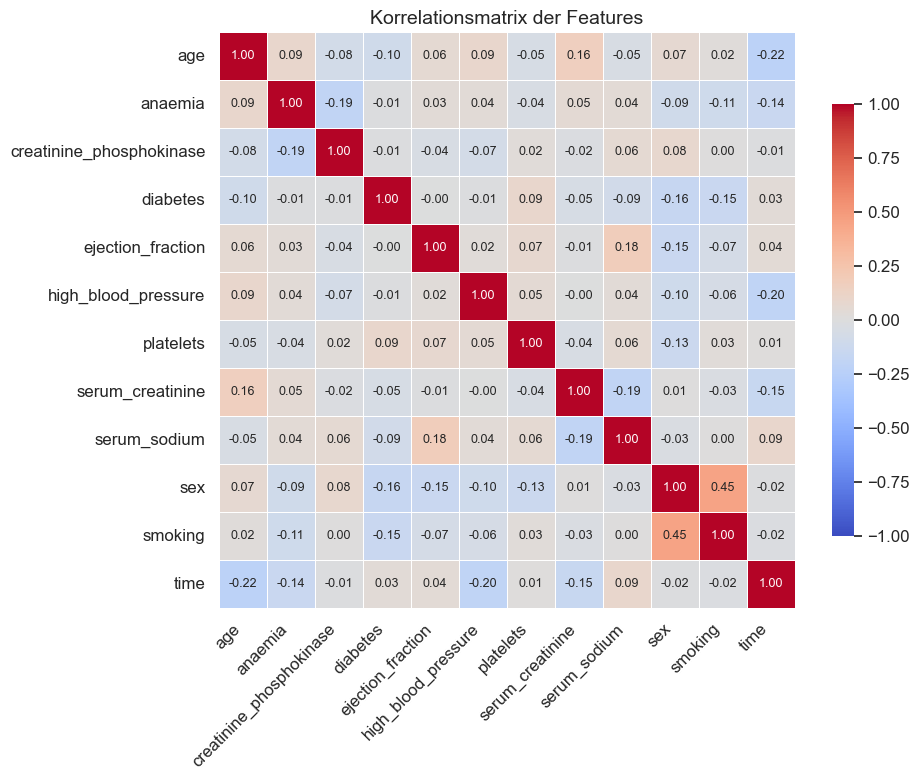

In [9]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))  # Mehr Platz für 12 Features
sns.set(font_scale=1.1)  # Größere Schrift für bessere Lesbarkeit
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",  # zwei Nachkommastellen
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={"shrink": 0.75},  # Farbleiste etwas kleiner
    linewidths=0.5,  # Gitterlinien zwischen Feldern
    annot_kws={"size": 9},  # Schriftgröße der Zahlen in den Feldern
)
plt.xticks(rotation=45, ha='right')  # Achsenbeschriftung lesbarer machen
plt.yticks(rotation=0)
plt.title("Korrelationsmatrix der Features", fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
correlations = X.corrwith(y)
from scipy.stats import pointbiserialr

correlations = {}
for col in X.columns:
    corr, _ = pointbiserialr(X[col], y)
    correlations[col] = corr
correlations_series = pd.Series(correlations).sort_values(key=lambda x: x.abs(), ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_series.values, y=correlations_series.index, palette="coolwarm")
plt.xlabel("Punktbiseriale Korrelation mit Zielvariable")
plt.title("Zusammenhang zwischen Features und Zielvariable")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

We can remove the feature "time".

Next we aim to scale our data. As a first step we take a look at the histograms to determine different range of values.

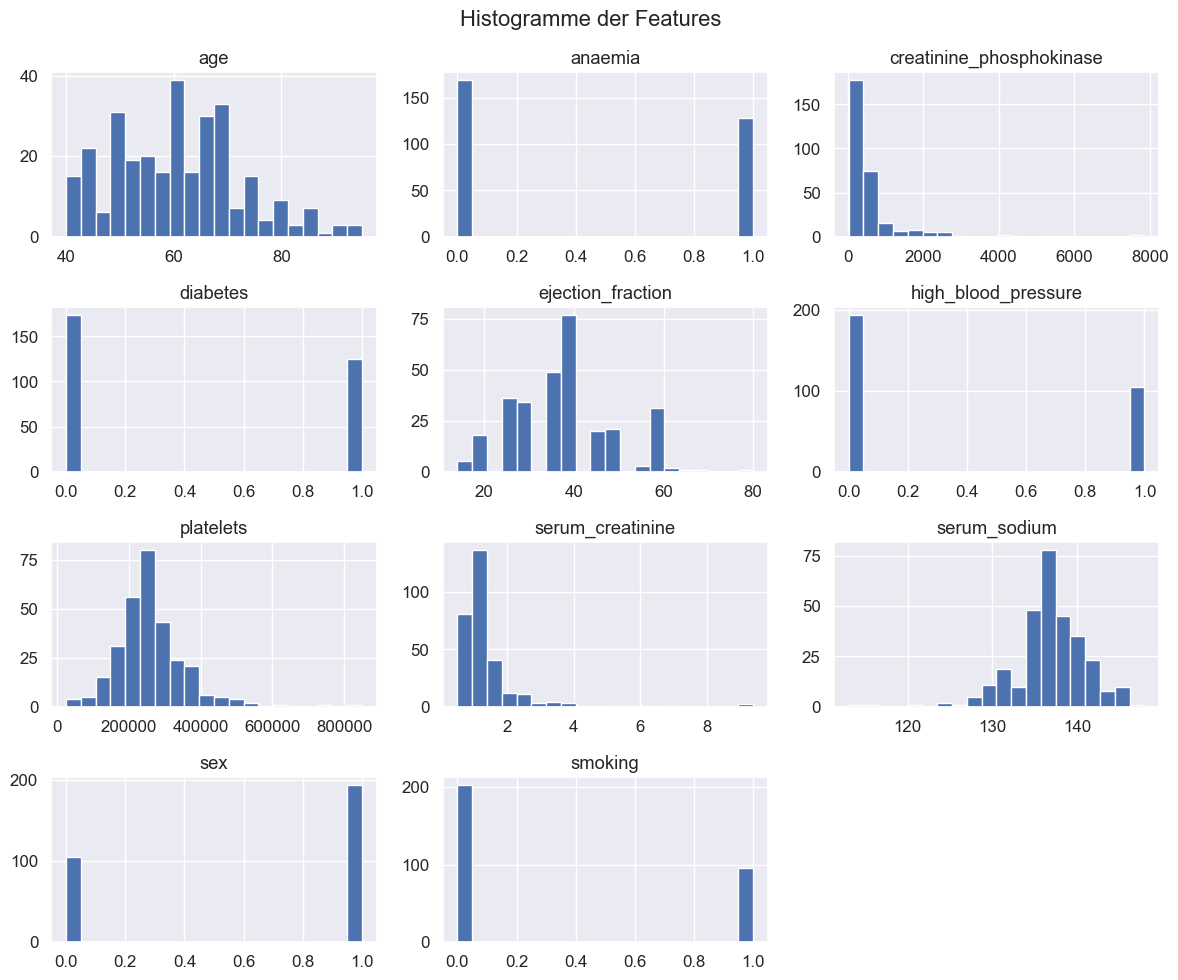

In [11]:
X = X.drop(columns=['time'])
X.hist(bins=20, figsize=(12, 10))
plt.suptitle("Histogramme der Features")
plt.tight_layout()
plt.show()

Wir müssen unsere Daten also skalieren!
Um unsere Ergebnisse besser interpretieren zu können, skalieren wir alle nichtbinären feature mit dem Standscaler()

Die Standardisierung erfolgt für jedes numerische Feature $x$ nach folgender Formel:


$x_{\text{scaled}} = \frac{x - \mu}{\sigma}$


- $ \mu $: Mittelwert des Features in den Trainingsdaten  
- $ \sigma $: Standardabweichung des Features in den Trainingsdaten

Für die binären Features wird keine Veränderung vorgenommen, sie bleiben unverändert.

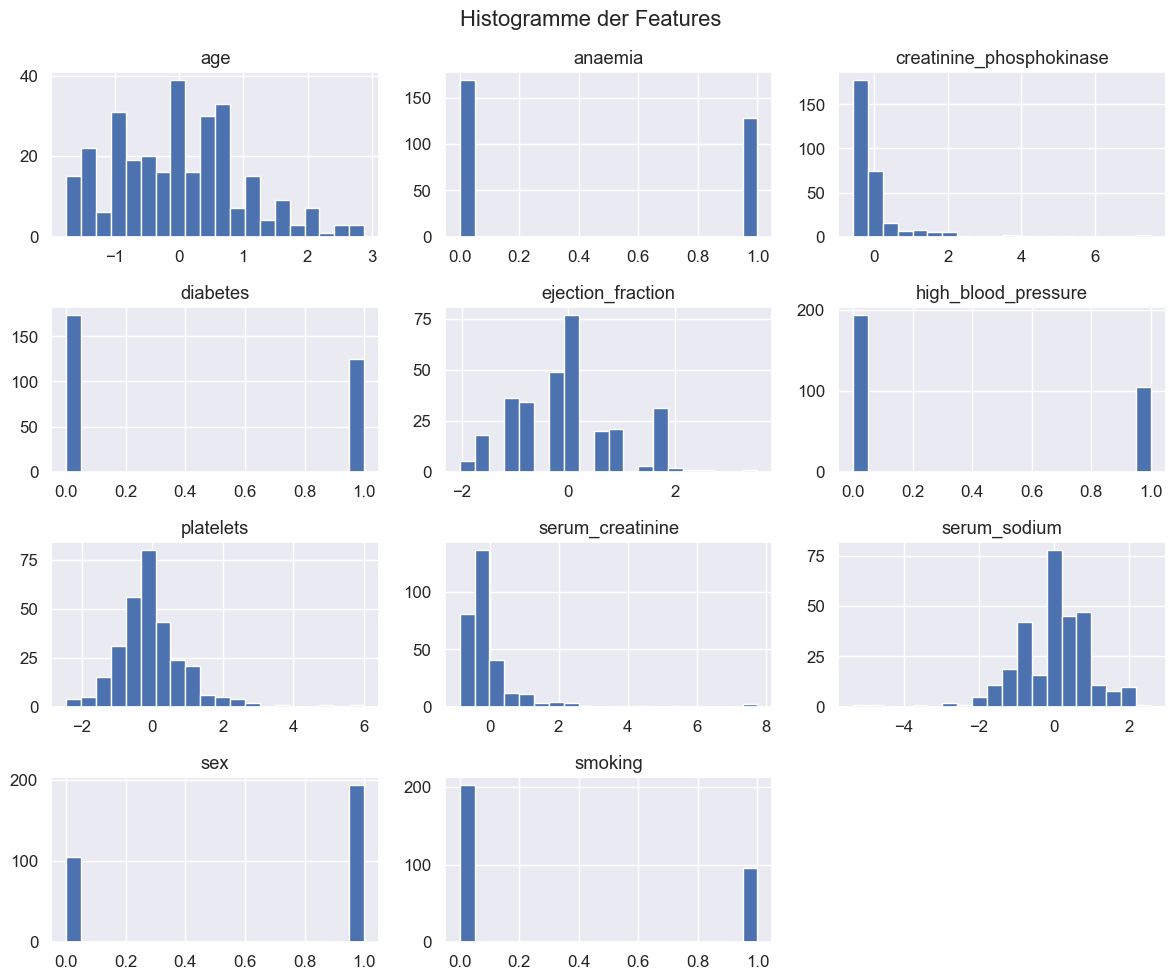

In [13]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['age', 'creatinine_phosphokinase',
       'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium']
scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.hist(bins=20, figsize=(12, 10))
plt.suptitle("Histogramme der Features")
plt.tight_layout()
plt.show()